### **Import Libraries**

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2


### **1. Load Dataset**

In [19]:
# Load training and test datasets
df_train = pd.read_csv('twitter_training.csv')
df_test = pd.read_csv("twitter_validation.csv")

In [20]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [21]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [22]:
# Add column names
df_train.columns = ['ID', 'Company', 'Sentiment', 'Tweet']
df_test.columns = ['ID', 'Company', 'Sentiment', 'Tweet']

In [23]:
# Display dataset info
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Company    74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [24]:
df_train.shape

(74681, 4)

In [25]:
df_test.shape

(999, 4)

In [26]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         999 non-null    int64 
 1   Company    999 non-null    object
 2   Sentiment  999 non-null    object
 3   Tweet      999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


### **2. Data Cleaning & Preprocessing**

In [27]:
# Check missing values
df_train.isnull().sum()

ID             0
Company        0
Sentiment      0
Tweet        686
dtype: int64

In [28]:
df_test.isnull().sum()

ID           0
Company      0
Sentiment    0
Tweet        0
dtype: int64

In [29]:
# Drop missing values
df_train.dropna(inplace=True)

In [30]:
# Check dupliacate values
df_train.duplicated().sum()

2340

In [31]:
df_test.duplicated().sum()

0

In [32]:
# Remove duplicate tweets
df_train.drop_duplicates(subset=['Tweet'], inplace=True)

In [33]:
df_train.duplicated().sum()

0

In [34]:
# Drop unnecessary columns
df_train.drop(columns=['ID', 'Company'], inplace=True)
df_test.drop(columns=['ID', 'Company'], inplace=True)

In [35]:
df_train.head()

,Sentiment,Tweet
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [36]:
df_test.head()

,Sentiment,Tweet
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [37]:
print(df_train["Sentiment"].value_counts())

Sentiment
Negative      21166
Positive      19066
Neutral       17042
Irrelevant    12216
Name: count, dtype: int64


In [38]:
df_train.shape

(69490, 2)

### **3. Data Cleaning - Removing Unwanted Characters**

In [39]:
def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d', ' ', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text.lower()

In [40]:
# Apply text cleaning
df_train['Tweet'] = df_train['Tweet'].apply(clean_tweet)
df_test['Tweet'] = df_test['Tweet'].apply(clean_tweet)

### **4. Data Visualization - Sentiment Distribution**

C:\Users\vaish\AppData\Local\Temp\ipykernel_34752\1235853755.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_train['Sentiment'], palette='viridis')


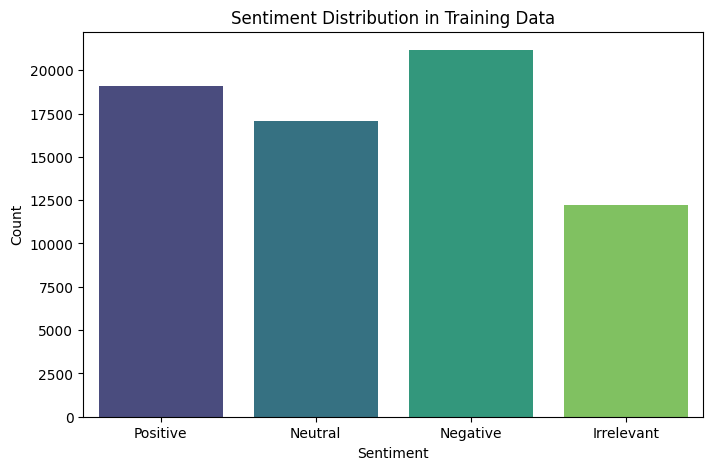

In [41]:
plt.figure(figsize=(8, 5))
sns.countplot(x=df_train['Sentiment'], palette='viridis')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

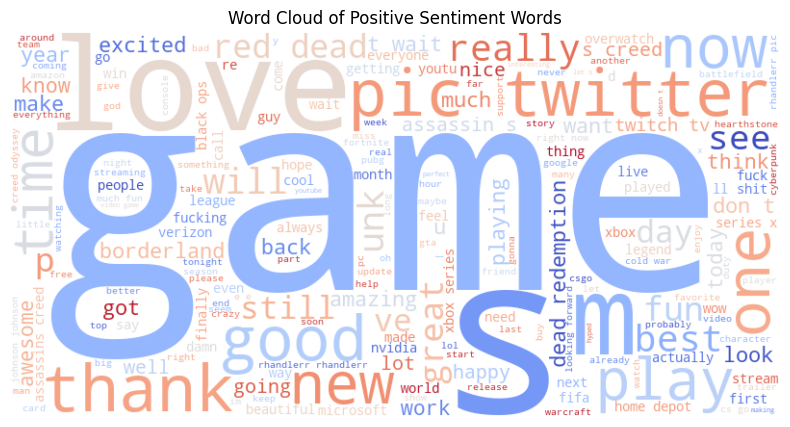

In [42]:

# Filter positive sentiment tweets
positive_tweets = df_train[df_train["Sentiment"] == "Positive"]["Tweet"]

# Combine all positive tweets into one text
text = " ".join(positive_tweets)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Sentiment Words")
plt.show()


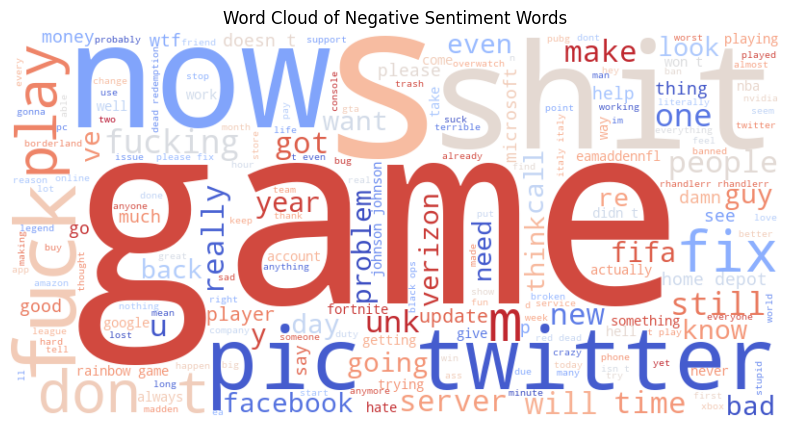

In [43]:
# Filter positive sentiment tweets
negative_tweets = df_train[df_train["Sentiment"] == "Negative"]["Tweet"]

# Combine all positive tweets into one text
text = " ".join(negative_tweets)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Negative Sentiment Words")
plt.show()


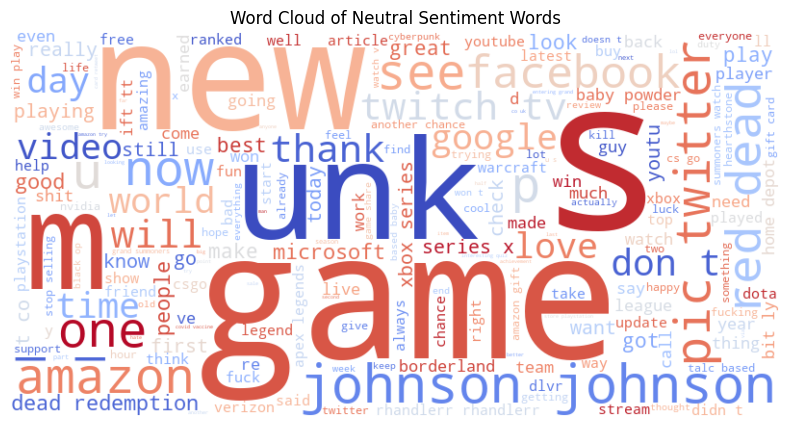

In [44]:
# Filter positive sentiment tweets
neutral_tweets = df_train[df_train["Sentiment"] == "Neutral"]["Tweet"]

# Combine all positive tweets into one text
text = " ".join(neutral_tweets)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Neutral Sentiment Words")
plt.show()


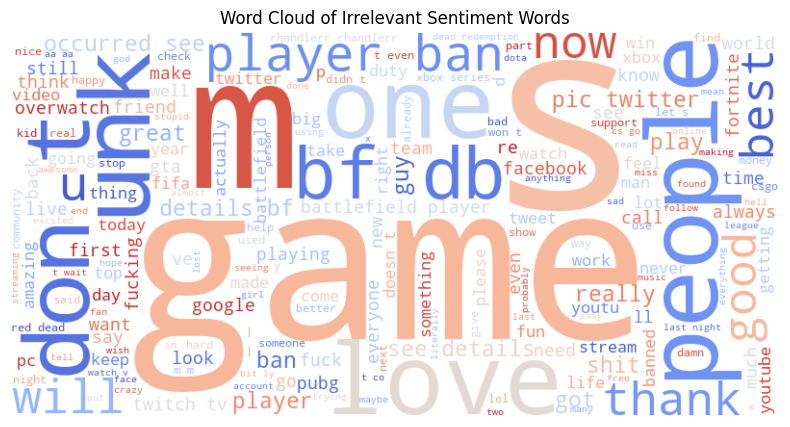

In [45]:
# Filter positive sentiment tweets
irrelevant_tweets = df_train[df_train["Sentiment"] == "Irrelevant"]["Tweet"]

# Combine all positive tweets into one text
text = " ".join(irrelevant_tweets)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Irrelevant Sentiment Words")
plt.show()


### **5. Tokenization & Padding**

In [46]:
# Separate features and labels for training data
train_texts = df_train['Tweet'].values
train_labels = df_train['Sentiment'].values

# Separate features and labels for test data
test_texts = df_test['Tweet'].values
test_labels = df_test['Sentiment'].values

In [47]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [48]:
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=30000, oov_token="<OOV>")  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)


In [49]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [50]:
maxlen=56
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [51]:
vocab_size = len(tokenizer.word_index) + 1  # +1 to account for padding/OOV token
vocab_size

29351

### **6. Build LSTM Model**

In [52]:
# Define the model
model = Sequential()

# Add an embedding layer 
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=56))


# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 4 units for 4 labels and softmax activation
model.add(Dense(4, activation='softmax'))

C:\Users\vaish\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [53]:
model.build(input_shape=(None, 56))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 56, 100)        │     2,935,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 56, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 56, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,344,000 (12.76 MB)

 Trainable params: 3,343,232 (12.75 MB)

 Non-trainable params: 768 (3.00 KB)

### **8. Compile & Train Model**

In [54]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    train_padded,
    train_labels_encoded ,
    validation_data=(test_padded,test_labels_encoded),
    epochs=10
)

Epoch 1/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 375s 170ms/step - accuracy: 0.4616 - loss: 8.4690 - val_accuracy: 0.7598 - val_loss: 0.7205
Epoch 2/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 286s 132ms/step - accuracy: 0.7848 - loss: 0.7098 - val_accuracy: 0.8569 - val_loss: 0.5183
Epoch 3/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 287s 132ms/step - accuracy: 0.8392 - loss: 0.5760 - val_accuracy: 0.7888 - val_loss: 0.6777
Epoch 4/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 278s 128ms/step - accuracy: 0.8662 - loss: 0.4947 - val_accuracy: 0.8188 - val_loss: 0.7067
Epoch 5/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 291s 134ms/step - accuracy: 0.8816 - loss: 0.4476 - val_accuracy: 0.8208 - val_loss: 0.6205
Epoch 6/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 306s 141ms/step - accuracy: 0.8915 - loss: 0.4155 - val_accuracy: 0.9209 - val_loss: 0.3388
Epoch 7/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 309s 142ms/step - accuracy: 0.8965 - loss: 0.3984 - val_accuracy: 0.9109 - val_loss: 0.3527
Epoch 8/10
2172/2172 ━━━━━━━━━━━━━━━━━━━━ 315s 145ms/step - ac

### **8. Evaluate Model**

In [55]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9198 - loss: 0.3128
Test Loss: 0.3225517272949219
Test Accuracy: 0.9229229092597961


### **9. Visualization of Training Performance**

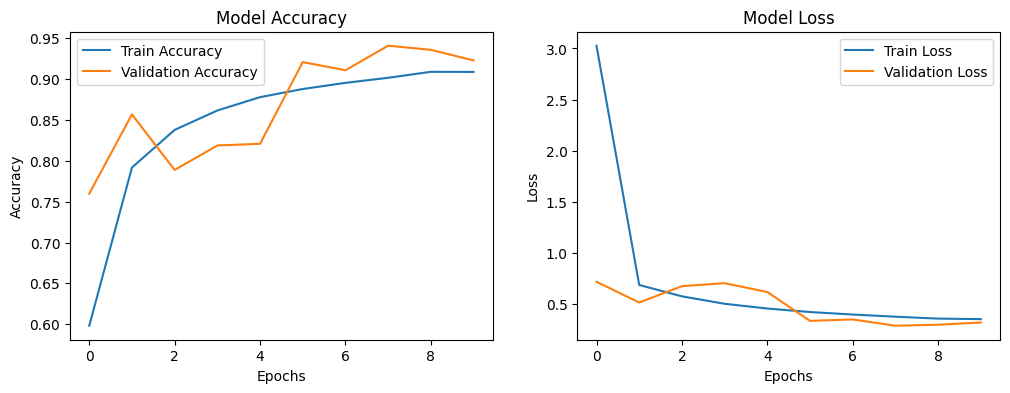

In [56]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
